# ABU量化系统使用文档 

<center>
        <img src="./image/abu_logo.png" alt="" style="vertical-align:middle;padding:10px 20px;"><font size="6" color="black"><b>第3节 滑点策略与交易手续费</b></font>
</center>

-----------------


作者: 阿布

阿布量化版权所有 未经允许 禁止转载

[abu量化系统github地址](https://github.com/bbfamily/abu) (欢迎+star)

[本节ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)

首先导入abupy中本节使用的模块：

In [1]:
from __future__ import print_function
from __future__ import division

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/df_kl.h5


上一节使用AbuFactorBuyBreak和AbuFactorSellBreak且混入基本止盈止损策略AbuFactorAtrNStop，
风险控制止损策略AbuFactorPreAtrNStop，利润保护止盈策略AbuFactorCloseAtrNStop来提高交易的盈利效果。

本节将继续在上一节回测的基础上示例择时策略其它使用方法，首先完成上一节的回测准备，如下所示：

In [2]:
from abupy import AbuFactorBuyBreak, AbuFactorSellBreak
from abupy import AbuFactorAtrNStop, AbuFactorPreAtrNStop, AbuFactorCloseAtrNStop
from abupy import ABuPickTimeExecute, AbuBenchmark, AbuCapital

# buy_factors 60日向上突破，42日向上突破两个因子
buy_factors = [{'xd': 60, 'class': AbuFactorBuyBreak}, 
               {'xd': 42, 'class': AbuFactorBuyBreak}]
# 四个卖出因子同时并行生效
sell_factors = [
    {
        'xd': 120,
        'class': AbuFactorSellBreak
    },
    {
        'stop_loss_n': 0.5,
        'stop_win_n': 3.0,
        'class': AbuFactorAtrNStop
    },
    {
        'class': AbuFactorPreAtrNStop,
        'pre_atr_n': 1.0
    },
    {
        'class': AbuFactorCloseAtrNStop,
        'close_atr_n': 1.5
    }]
benchmark = AbuBenchmark()
capital = AbuCapital(1000000, benchmark)

### 1  滑点买入卖出价格确定及策略实现

第一节中实现的买入策略和卖出策略的编写，买入策略中确定买入只是通过make_buy_order函数，确定买单生成，卖出策略确定卖出订单
也只是通过fit_sell_order来提交卖单，那么执行订单，应该使用的什么价格买入或者卖出呢，abupy在默认的策略都是使用当天的均价买入卖出，

当然你可以实现多种复杂的当日交易策略，设置限价单、市价单，获取当日的分时数据再次进行策略分析执行操作，但是如果你的回测数量足够多的情况下，比如全市场回测，按照大数定理，这个均值执行其实是最好的模拟，而且简单、运行速度快。

滑点买入卖出价格确定具体实现代码请阅读AbuSlippageBuyMean和AbuSlippageSellMean，它们的实现都很简单

在买入滑点AbuSlippageBuyMean中有一个小策略当当天开盘价格直接下探7%时，放弃买单，看上一节回测结果中如下图这次交易，从图上就可以发现虽然是突破买入，但明显第二天执行买单时的价格是直线下跌的，且下跌不少，但还是成交了这笔交易。因为开盘下跌幅度没有达到7%的阀值，下面我们就过拟合这次交易避免买入，只为示例

![](./image/3.1.png)

下面编写一个独立的Slippage策略，只简单修改g_open_down_rate的值为0.02

In [3]:
from abupy import AbuSlippageBuyBase, slippage
# 修改买入下跌阀值为0.02
g_open_down_rate = 0.02

class AbuSlippageBuyMean2(AbuSlippageBuyBase):
    """示例日内滑点均价买入类"""

    @slippage.sbb.slippage_limit_up
    def fit_price(self):
        """
        取当天交易日的最高最低均价做为决策价格
        :return: 最终决策的当前交易买入价格
        """
        # TODO 基类提取作为装饰器函数，子类根据需要选择是否装饰，并且添加上根据order的call，put明确细节逻辑
        if self.kl_pd_buy.pre_close == 0 or (self.kl_pd_buy.open / self.kl_pd_buy.pre_close) < (1 - g_open_down_rate):
            # 开盘就下跌一定比例阀值，放弃单子
            return np.inf
        # 买入价格为当天均价，即最高，最低的平均，也可使用高开低收平均等方式计算
        self.buy_price = np.mean([self.kl_pd_buy['high'], self.kl_pd_buy['low']])
        # 返回最终的决策价格
        return self.buy_price

上面编写的AbuSlippageBuyMean2类实现即为滑点买入类的实现：

1. 滑点买入类需要继承自AbuSlippageBuyBase
2. 滑点买入类需要实现fit_price来确定交易单执行当日的最终买入价格
3. slippage_limit_up装饰器是针对a股涨停板买入价格决策的装饰器，处理买入成功概率，根据概率决定是否能买入，及涨停下的买入价格决策，涨停下买入价格模型为，越靠近涨停价格买入成交概率越大，即在涨停下预期以靠近涨停价格买入，

备注：slippage_limit_up及slippage_limit_down具体实现可阅读源代码，后面的章节有示例演示使用

但是滑点类时什么时候被实例化使用的呢，怎么使用我们自己写的这个滑点类呢？首先看买入因子基类AbuFactorBuyBase，在每个买入因子初始化的时候即把默认的滑点类以及仓位管理类（稍后讲解）赋值，如下片段代码所示：

详情请查看AbuFactorBuyBas源代码

    class AbuFactorBuyBase(six.with_metaclass(ABCMeta, ABuParamBaseClass)):
        def __init__(self, capital, kl_pd, **kwargs):
            # 走势数据
            self.kl_pd = kl_pd
            # 资金情况数据
            self.capital = capital
            # 滑点类，默认AbuSlippageBuyMean
            self.slippage_class = kwargs['slippage'] \
                if 'slippage' in kwargs else AbuSlippageBuyMean
            # 仓位管理，默认AbuAtrPosition
            self.position_class = kwargs['position'] \
                if 'position' in kwargs else AbuAtrPosition
            if 'win_rate' in kwargs:
                self.win_rate = kwargs['win_rate']
            if 'gains_mean' in kwargs:
                self.gains_mean = kwargs['gains_mean']
            if 'losses_mean' in kwargs:
                self.losses_mean = kwargs['losses_mean']
            self._init_self(**kwargs)

之后因子在每次生效产生买单的时候会触发AbuOrder实例对象的fit_buy_order()函数，fit_buy_order()中将滑点类，仓位管理类实例化后，执行买入价格及数量确定，代码片段如下所示，详情请查看源代码。
    
    def fit_buy_order(self, day_ind, factor_object):
        kl_pd = factor_object.kl_pd
        # 要执行买入当天的数据
        kl_pd_buy = kl_pd.iloc[day_ind + 1]
        # 买入因子名称
        factor_name = factor_object.factor_name \
            if hasattr(factor_object, 'factor_name') else 'unknown'
        # 滑点类设置
        slippage_class = factor_object.slippage_class
        # 仓位管理类设置
        position_class = factor_object.position_class
        # 初始资金，也可修改策略使用剩余资金
        read_cash = factor_object.capital.read_cash
        # 实例化滑点类
        fact = slippage_class(kl_pd_buy, factor_name)
        # 执行fit_price(), 计算出买入价格
        bp = fact.fit_price()
        # 如果滑点类中决定不买入，撤单子，bp就返回正无穷
        if bp < np.inf:
            # 实例化仓位管理类
            position = position_class(kl_pd_buy, factor_name, bp, 
                                      read_cash)
            # 执行fit_position()，通过仓位管理计算买入的数量
            buy_stock_cnt = int(position.fit_position(factor_object))
            if buy_stock_cnt < 1:
                return

卖出因子的滑点操作及仓位管理与买入类似，读者可以自行阅读源代码。

由以上代码我们可以发现通过buy_factors的字典对象中传入slippage便可以自行设置滑点类，由于上图显示的交易是60日突破产生的买单，所以我们只修改60日突破的字典对象，执行后可以看到如下图所示，过滤了两个60日突破的买单，即过滤了上图所示的交易，代码如下所示：

备注：实际上如果只是修改g_open_down_rate的值，可以通过模块全局变量直接修改，本节只为示例使用流程

pid:7785 pick times complete:100.0%


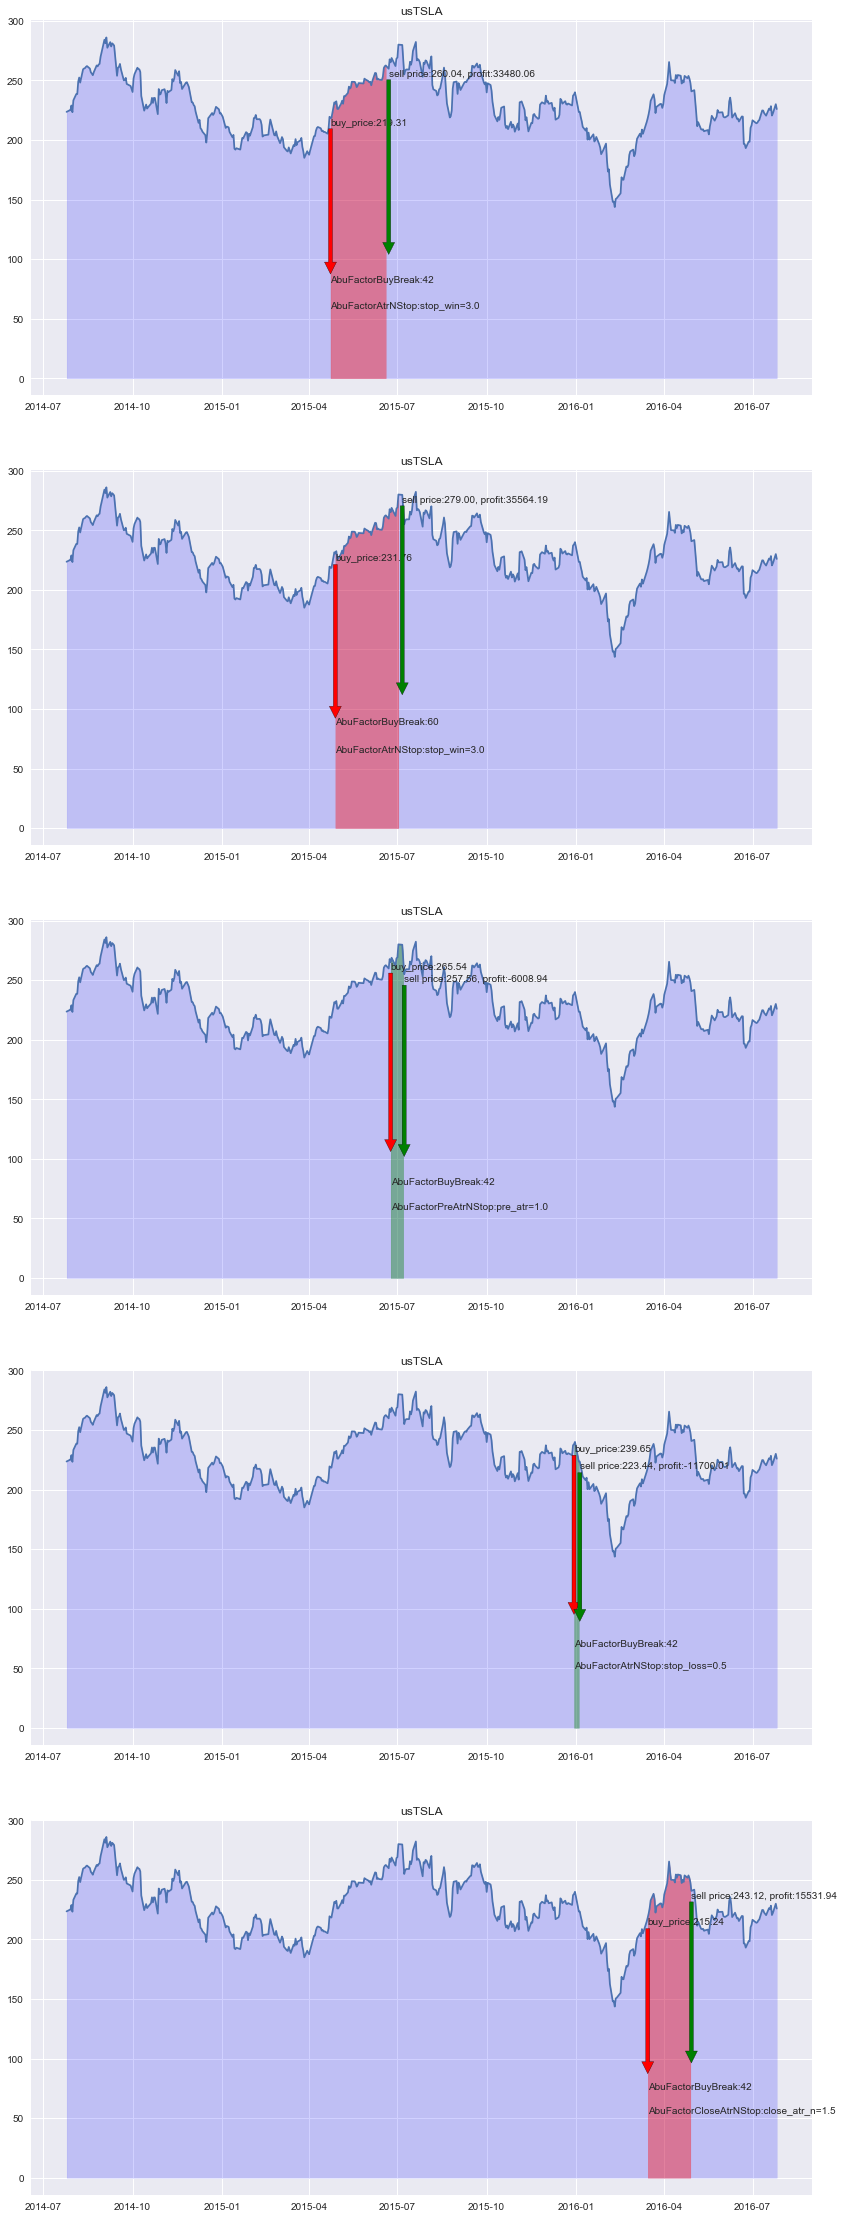

pid:7785 done!


In [4]:
# 针对60使用AbuSlippageBuyMean2
buy_factors2 = [{'slippage': AbuSlippageBuyMean2, 'xd': 60,
                 'class': AbuFactorBuyBreak},
                {'xd': 42, 'class': AbuFactorBuyBreak}]
capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, _ = ABuPickTimeExecute.do_symbols_with_same_factors(['usTSLA'],
                                                                            benchmark,
                                                                            buy_factors2,
                                                                            sell_factors,
                                                                            capital,
                                                                            show=True)

### 2. 交易手续费的计算以及自定义手续费

交易必然会产生手续费，手续费的计算在ABuCommission模块中，比如本例中使用的的美股交易回测，使用的手续费计算代码如下所示：
    
    def calc_commission_us(trade_cnt, price):
        """
        美股计算交易费用：每股0.01，最低消费2.99
        :param trade_cnt: 交易的股数（int）
        :param price: 每股的价格（美元）（暂不使用，只是保持接口统一）
        :return: 计算结果手续费
        """
        # 每股手续费0.01
        commission = trade_cnt * 0.01
        if commission < 2.99:
            # 最低消费2.99
            commission = 2.99
        return commission
        
针对不同市场美股，a股，港股，比特币，期货有不同计算手续费的方法，更多详情请阅读ABuCommission模块源代码

下面先看看之前的回测交易中产生的手续费情况，查看代码如下所示：

In [5]:
capital.commission.commission_df

,type,date,symbol,commission
0,buy,20150423,usTSLA,8.22
0,buy,20150428,usTSLA,7.53
0,sell,20150622,usTSLA,8.22
0,buy,20150624,usTSLA,7.53
0,sell,20150706,usTSLA,7.53
0,sell,20150708,usTSLA,7.53
0,buy,20151230,usTSLA,7.22
0,sell,20160105,usTSLA,7.22
0,buy,20160315,usTSLA,5.57
0,sell,20160429,usTSLA,5.57


如果你想把自己的计算手续费的方法使用在回测中，只需要编写手续费函数，示例如下所示：

In [6]:
def calc_commission_us2(trade_cnt, price):
    """
        手续费统一7美元
    """
    return 7

如上编写的手续费函数统一每次买入卖出都是7美元手续费，手续费函数有两个参数一个trade_cnt代表买入（卖出）股数，
另一个参数是price，代表买入（卖出）价格，下面使用这个自定义的手续费方法做回测，代码如下所示：

In [7]:
# 构造一个字典key='buy_commission_func', value=自定义的手续费方法函数
commission_dict = {'buy_commission_func': calc_commission_us2}
# 将commission_dict做为参数传入AbuCapital
capital = AbuCapital(1000000, benchmark, user_commission_dict=commission_dict)
# 除了手续费自定义外，回测其它设置不变，show=False不可视化回测交易
orders_pd, action_pd, _ = ABuPickTimeExecute.do_symbols_with_same_factors(['usTSLA'],
                                                                            benchmark,
                                                                            buy_factors2,
                                                                            sell_factors,
                                                                            capital,
                                                                            show=False)
# 回测完成后查看手续费情况
capital.commission.commission_df

pid:79242 pick times complete:100.0%
pid:79242 done!


,type,date,symbol,commission
0,buy,20150423,usTSLA,7
0,buy,20150428,usTSLA,7
0,sell,20150622,usTSLA,8.22
0,buy,20150624,usTSLA,7
0,sell,20150706,usTSLA,7.53
0,sell,20150708,usTSLA,7.53
0,buy,20151230,usTSLA,7
0,sell,20160105,usTSLA,7.22
0,buy,20160315,usTSLA,7
0,sell,20160429,usTSLA,5.57


从上面回测交易手续费结果可以看到，买入的手续费都变成了7元，卖出手续费还是之前的算法，下面的回测将买入卖出手续费计算方法都变成使用自定义的方法，代码如下所示：

In [8]:
# 卖出字典key='sell_commission_func', 指向同一个手续费方法，当然也可以定义不同的方法
commission_dict = {'buy_commission_func': calc_commission_us2, 'sell_commission_func': calc_commission_us2}
# 将commission_dict做为参数传入AbuCapital
capital = AbuCapital(1000000, benchmark, user_commission_dict=commission_dict)
# 除了手续费自定义外，回测其它设置不变，show=False不可视化回测交易
orders_pd, action_pd, _ = ABuPickTimeExecute.do_symbols_with_same_factors(['usTSLA'],
                                                                            benchmark,
                                                                            buy_factors2,
                                                                            sell_factors,
                                                                            capital,
                                                                            show=False)
# 回测完成后查看手续费情况
capital.commission.commission_df

pid:79242 pick times complete:100.0%
pid:79242 done!


,type,date,symbol,commission
0,buy,20150423,usTSLA,7
0,buy,20150428,usTSLA,7
0,sell,20150622,usTSLA,7
0,buy,20150624,usTSLA,7
0,sell,20150706,usTSLA,7
0,sell,20150708,usTSLA,7
0,buy,20151230,usTSLA,7
0,sell,20160105,usTSLA,7
0,buy,20160315,usTSLA,7
0,sell,20160429,usTSLA,7


从回测结果即可以看到所有买入卖出的手续费都是7美元

#### abu量化文档目录章节

1. [择时策略的开发](http://www.abuquant.com/lecture/lecture_1.html)
2. [择时策略的优化](http://www.abuquant.com/lecture/lecture_2.html)
3. [滑点策略与交易手续费](http://www.abuquant.com/lecture/lecture_3.html)
4. [多支股票择时回测与仓位管理](http://www.abuquant.com/lecture/lecture_4.html)
5. [选股策略的开发](http://www.abuquant.com/lecture/lecture_5.html)
6. [回测结果的度量](http://www.abuquant.com/lecture/lecture_6.html)
7. [寻找策略最优参数和评分](http://www.abuquant.com/lecture/lecture_7.html)
8. [A股市场的回测](http://www.abuquant.com/lecture/lecture_8.html)
9. [港股市场的回测](http://www.abuquant.com/lecture/lecture_9.html)
10. [比特币，莱特币的回测](http://www.abuquant.com/lecture/lecture_10.html)
11. [期货市场的回测](http://www.abuquant.com/lecture/lecture_11.html)
12. [机器学习与比特币示例](http://www.abuquant.com/lecture/lecture_12.html)
13. [量化技术分析应用](http://www.abuquant.com/lecture/lecture_13.html)
14. [量化相关性分析应用](http://www.abuquant.com/lecture/lecture_14.html)
15. [量化交易和搜索引擎](http://www.abuquant.com/lecture/lecture_15.html)
16. [UMP主裁交易决策](http://www.abuquant.com/lecture/lecture_16.html)
17. [UMP边裁交易决策](http://www.abuquant.com/lecture/lecture_17.html)
18. [自定义裁判决策交易](http://www.abuquant.com/lecture/lecture_18.html)
19. [数据源](http://www.abuquant.com/lecture/lecture_19.html)
20. [A股全市场回测](http://www.abuquant.com/lecture/lecture_20.html)
21. [A股UMP决策](http://www.abuquant.com/lecture/lecture_21.html)
22. [美股全市场回测](http://www.abuquant.com/lecture/lecture_22.html)
23. [美股UMP决策](http://www.abuquant.com/lecture/lecture_23.html)

abu量化系统文档教程持续更新中，请关注公众号中的更新提醒。

#### 《量化交易之路》目录章节及随书代码地址

1. [第二章 量化语言——Python](https://github.com/bbfamily/abu/tree/master/ipython/第二章-量化语言——Python.ipynb)
2. [第三章 量化工具——NumPy](https://github.com/bbfamily/abu/tree/master/ipython/第三章-量化工具——NumPy.ipynb)
3. [第四章 量化工具——pandas](https://github.com/bbfamily/abu/tree/master/ipython/第四章-量化工具——pandas.ipynb)
4. [第五章 量化工具——可视化](https://github.com/bbfamily/abu/tree/master/ipython/第五章-量化工具——可视化.ipynb)
5. [第六章 量化工具——数学：你一生的追求到底能带来多少幸福](https://github.com/bbfamily/abu/tree/master/ipython/第六章-量化工具——数学.ipynb)
6. [第七章 量化系统——入门：三只小猪股票投资的故事](https://github.com/bbfamily/abu/tree/master/ipython/第七章-量化系统——入门.ipynb)
7. [第八章 量化系统——开发](https://github.com/bbfamily/abu/tree/master/ipython/第八章-量化系统——开发.ipynb)
8. [第九章 量化系统——度量与优化](https://github.com/bbfamily/abu/tree/master/ipython/第九章-量化系统——度量与优化.ipynb)
9. [第十章 量化系统——机器学习•猪老三](https://github.com/bbfamily/abu/tree/master/ipython/第十章-量化系统——机器学习•猪老三.ipynb)
10. [第十一章 量化系统——机器学习•ABU](https://github.com/bbfamily/abu/tree/master/ipython/第十一章-量化系统——机器学习•ABU.ipynb)
11. [附录A 量化环境部署](https://github.com/bbfamily/abu/tree/master/ipython/附录A-量化环境部署.ipynb)
12. [附录B 量化相关性分析](https://github.com/bbfamily/abu/tree/master/ipython/附录B-量化相关性分析.ipynb)
13. [附录C 量化统计分析及指标应用](https://github.com/bbfamily/abu/tree/master/ipython/附录C-量化统计分析及指标应用.ipynb)

[更多阿布量化量化技术文章](http://www.abuquant.com/article)

更多关于量化交易相关请阅读[《量化交易之路》](http://www.abuquant.com/books/quantify-trading-road.html)

更多关于量化交易与机器学习相关请阅读[《机器学习之路》](http://www.abuquant.com/books/machine-learning-road.html)

更多关于abu量化系统请关注微信公众号: abu_quant

![](./image/qrcode.jpg)